<font size = "5">

 Final  Project 
 QTM 151, Fall 2023

<font size = "3">

- By  Christina Xu, Shawn Chen, Shan Lu
- Merge the tables "lap_times" (primary) and "drivers" (secondary) <br>
on "driverId" using ```LEFT JOIN``` on "driverId".

HINT: Include \\"driverId\\" in double quotations with an <br>
escape character (see Lecture 20 for details) since <br>
it has a mix of upper and lower case letters

<font size = "5">

 Introduction

<font size = "3">

Data cleaning:

In [20]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl 
import matplotlib.pyplot as plt

In [28]:
# Importing the Datasets
drivers=pd.read_csv("raw_data/drivers.csv")
#pit_stops table
pit_stops=pd.read_csv("raw_data/pit_stops.csv")
#results table
results  = pd.read_csv("raw_data/results.csv")
#races table
races= pd.read_csv("raw_data/races.csv")
#pit stops
pit_stops=pd.read_csv("raw_data/pit_stops.csv")


# Renaming the 'milliseconds' column in the pit_stops dataframe to 'stopmilliseconds, to differentiate from 'milliseconds in the results table'


In [66]:
# Merging the datasets:
# merge races and results datasets on 'raceId'
merged = pd.merge(races, results, on='raceId')


# Calculating the mean of pit stop times for each driver in each race
pit_stops_mean = pit_stops.groupby(['raceId', 'driverId'])['milliseconds'].mean().reset_index()

# Merging the mean of pit stop times with the races and results data
merged = pd.merge(pit_stops_mean,
                       merged[['raceId','driverId','year','date','positionOrder']],
                           on=['raceId', 'driverId'],
                           how="right")

#Renamed the milliseconds column to indivate its purpose
final_merged = merged.rename(columns={'milliseconds': 'stopmilliseconds_mean'})


#The merged dataframe has all the columns from races, pit stops, and results. 
display(final_merged)

,raceId,driverId,stopmilliseconds_mean,year,date,positionOrder
0,1,18,NaN,2009,2009-03-29,1
1,1,22,NaN,2009,2009-03-29,2
2,1,15,NaN,2009,2009-03-29,3
3,1,10,NaN,2009,2009-03-29,4
4,1,4,NaN,2009,2009-03-29,5
...,...,...,...,...,...,...
7082,1096,839,21814.5,2022,2022-11-20,7
7083,1096,840,21808.0,2022,2022-11-20,8
7084,1096,817,21893.0,2022,2022-11-20,9
7085,1096,20,23186.0,2022,2022-11-20,10


In [62]:
# Sorting values by year and date to get races in chronological order
merged_sorted = final_merged.sort_values(by=['year', 'date', 'raceId'])

In [67]:
# Creating a shifted dataframe to find the next race for each driver in the same season
# We shift the 'raceId' and 'positionOrder' within the group defined by each driverId and year
merged_sorted['next_raceId'] = merged_sorted.groupby(['year', 'driverId'])['raceId'].shift(-1)
merged_sorted['next_positionOrder'] = merged_sorted.groupby(['year', 'driverId'])['positionOrder'].shift(-1)

# Remove the last race of the season for that driver
regression_df_corrected = merged_sorted.dropna(subset=['next_raceId'])

# ensurring the race ID has shifted
regression_df_corrected = regression_df_corrected[regression_df_corrected['raceId'] != regression_df_corrected['next_raceId']]

regression_df_corrected.head(10)


,raceId,driverId,stopmilliseconds_mean,positionOrder,year,date,next_raceId,next_positionOrder
0,841,1,23213.000000,2,2011,2011-03-27,842.0,8.0
1,841,4,24055.000000,4,2011,2011-03-27,842.0,6.0
2,841,13,24145.666667,7,2011,2011-03-27,842.0,5.0
3,841,17,24058.666667,5,2011,2011-03-27,842.0,4.0
4,841,18,20950.333333,6,2011,2011-03-27,842.0,2.0
5,841,20,23319.500000,1,2011,2011-03-27,842.0,1.0
6,841,808,25109.000000,3,2011,2011-03-27,843.0,9.0
7,842,1,23252.750000,8,2011,2011-04-10,843.0,1.0
8,842,2,23241.000000,3,2011,2011-04-10,843.0,12.0
9,842,4,24510.000000,6,2011,2011-04-10,843.0,7.0


21996.0

28097.5

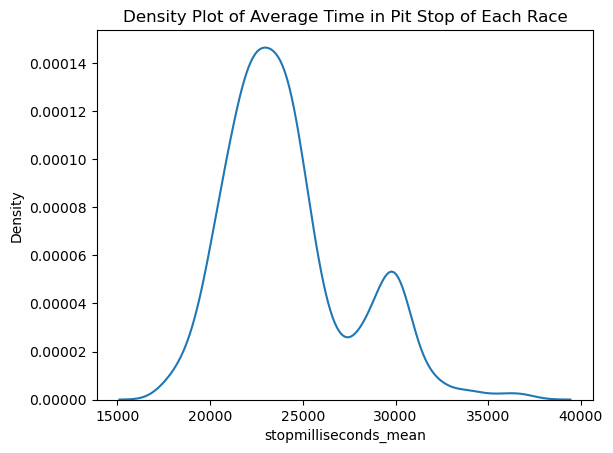

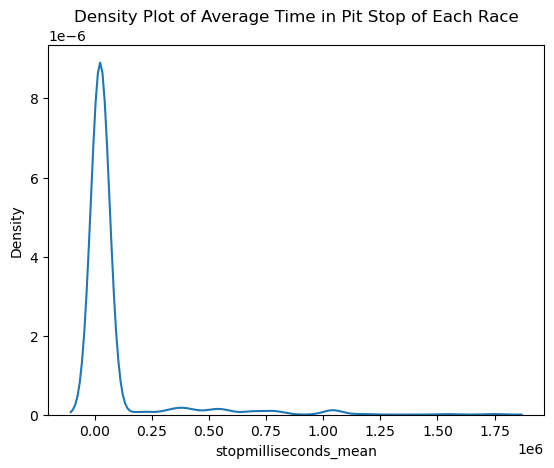

In [49]:
#In here, we filtered the ouliers out by calculating the interquartile range and visualized the filtered results by density plot.
import seaborn as sns
#Calculating the first and third quartiles (Q1 and Q3)
Q1= regression_df_corrected['stopmilliseconds_mean'].quantile(0.25)
display(Q1)
Q3= regression_df_corrected['stopmilliseconds_mean'].quantile(0.75)
display(Q3)

#Calculating the interquartile range
IQR = Q3 - Q1
#Filter out the outliers by selecting the dataset within the interquartile range
regression_df_corrected_filtered = regression_df_corrected[(regression_df_corrected['stopmilliseconds_mean'] >= Q1 - 1.5 * IQR) & (regression_df_corrected['stopmilliseconds_mean'] <= Q3 + 1.5 * IQR)]

#Visualizing the distribution of stopmilliseconds in density plot
sns.kdeplot(regression_df_corrected_filtered['stopmilliseconds_mean'])
plt.title('Density Plot of Average Time in Pit Stop of Each Race')
plt.show()

sns.kdeplot(regression_df_corrected['stopmilliseconds_mean'])
plt.title('Density Plot of Average Time in Pit Stop of Each Race before cleaning')
plt.show()

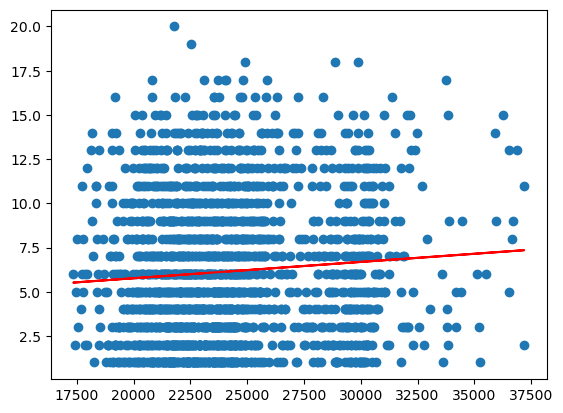

In [11]:
#Draw scatter plot with the line of best fit. (x=time consumption in pit stop of current race, y=position order of the driver in next race) 
x= regression_df_corrected_filtered['stopmilliseconds_mean']
y= regression_df_corrected_filtered['next_positionOrder']
slope, intercept = np.polyfit(x, y, 1)

# Generate points for the line of best fit
line_of_best_fit = slope * x + intercept

# Plot the original data and the line of best fit
plt.scatter(x, y, label='Data points')
plt.plot(x, line_of_best_fit, color='red', label='Line of Best Fit')

Text(0, 0.5, 'Average time consumed in pit stop (millisecond)')

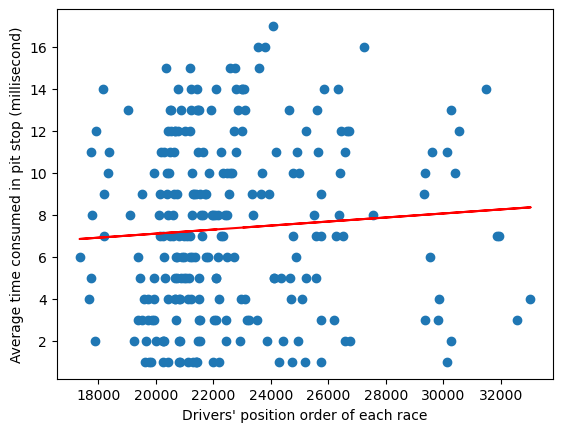

In [45]:
# We then randomly selected the dataframe in the same season 2012, so the rules of the races are consistant. 
season_results_2012=regression_df_corrected_filtered.query('year==2012')
x= season_results_2012['stopmilliseconds_mean']
y= season_results_2012['next_positionOrder']
slope, intercept = np.polyfit(x, y, 1)

# Generate points for the line of best fit
line_of_best_fit = slope * x + intercept

# Plot the original data and the line of best fit
plt.scatter(x, y, label='Data points')
plt.plot(x, line_of_best_fit, color='red', label='Line of Best Fit')
plt.title('')
plt.xlabel("Drivers' position order of each race")
plt.ylabel("Average time consumed in pit stop (millisecond)")
